In [6]:
import torch
import numpy as np

# 假设您的onn.py文件在当前路径下
from onn import Net # 导入您的Net类

# 实例化模型
model = Net(num_layers=5) # 确保num_layers与您训练时一致
# 如果您的模型是在GPU上训练的，确保将其移动到CPU以便保存或在CPU上加载
model.load_state_dict(torch.load("./saved_model/136_model.pth", map_location=torch.device('cpu')))
model.eval() # 将模型设置为评估模式

# 获取每一层的相位图
all_phase_maps = []
# 遍历每一层
for i in range(model.num_layers):
    # 提取原始相位数据
    raw_phase = model.phase[i].data.cpu().numpy()
    
    # 对相位进行取模运算，将其约束在 [0, 2*pi) 的范围内
    # np.fmod 可以正确处理负数，结果符号与被除数相同
    # 但我们希望结果是正数，所以可以使用 `(raw_phase % (2 * np.pi) + (2 * np.pi)) % (2 * np.pi)`
    # 或者直接使用np.mod
    bounded_phase = np.mod(raw_phase, 2 * np.pi)
    
    all_phase_maps.append(bounded_phase)

# 示例：查看第一层修正后的相位图
print(f"修正后第一层相位图的形状: {all_phase_maps[0].shape}")
print(f"修正后第一层相位图的值范围: [{np.min(all_phase_maps[0])}, {np.max(all_phase_maps[0])}]")# 假设您已经通过仿真获得了相位-高度的查找表




# 真实场景中，这会是一个更复杂的插值过程
# 这是一个简化的示例，假设 n_eff 是一个常量（实际上不是）
# 您需要根据您的设计和仿真来获取这些值
n_material = 2.0 # 示例值，取决于您的介质柱材料
n_env = 1.0     # 空气折射率
# 从Net中的第一个衍射层实例获取波长
lambda_0 = model.diffractive_layers[0].wl

# 假设 n_eff 为某个常数，这在实际中是不准确的，需要仿真得到
# 真实的 n_eff 会随结构几何参数变化
effective_n_diff = 0.5 # 示例值：(n_eff - n_env) 的近似值，需要通过仿真确定

all_height_maps = []
for phase_map_rad in all_phase_maps:
    # 确保相位值在 0 到 2pi 之间（您的模型已经处理了）
    # 论文中通常使用0到2pi，因为超过2pi的相位可以通过减少2pi来等效
    # height_map = (phase_map_rad * lambda_0) / (2 * np.pi * effective_n_diff)

    # 实际应用中，您会使用插值查找表：
    # 例如：height_map = interpolate_from_lookup_table(phase_map_rad, lookup_table_from_FDTD_sim)
    
    # 简单示例：直接转换，仅作演示，实际需要仿真数据
    height_map = phase_map_rad * (lambda_0 / (2 * np.pi * effective_n_diff))
    
    all_height_maps.append(height_map)
    
print(f"第一层超表面高度图的形状: {all_height_maps[0].shape}")
print(f"第一层超表面高度图的值范围: [{np.min(all_height_maps[0])}, {np.max(all_height_maps[0])}] (单位：米)")


import pandas as pd

output_dir = "metasurface_designs/"
import os
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for i, height_map in enumerate(all_height_maps):
    df_height = pd.DataFrame(height_map)
    csv_filename = os.path.join(output_dir, f"metasurface_layer_{i+1}_height.csv")
    df_height.to_csv(csv_filename, index=False, header=False)
    print(f"保存超表面高度图到: {csv_filename}")

from PIL import Image

for i, height_map in enumerate(all_height_maps):
    # 归一化高度图到 0-255
    min_h = np.min(height_map)
    max_h = np.max(height_map)
    if max_h == min_h: # 避免除以零
        normalized_height_map = np.zeros_like(height_map)
    else:
        normalized_height_map = ((height_map - min_h) / (max_h - min_h) * 255).astype(np.uint8)

    img = Image.fromarray(normalized_height_map, mode='L') # 'L' 代表灰度图
    png_filename = os.path.join(output_dir, f"metasurface_layer_{i+1}_height.png")
    img.save(png_filename)
    print(f"保存超表面高度图到: {png_filename}")    

修正后第一层相位图的形状: (200, 200)
修正后第一层相位图的值范围: [4.38690185546875e-05, 6.282481670379639]
第一层超表面高度图的形状: (200, 200)
第一层超表面高度图的值范围: [1.0472956724072446e-08, 0.0014998320257291198] (单位：米)
保存超表面高度图到: metasurface_designs/metasurface_layer_1_height.csv
保存超表面高度图到: metasurface_designs/metasurface_layer_2_height.csv
保存超表面高度图到: metasurface_designs/metasurface_layer_3_height.csv
保存超表面高度图到: metasurface_designs/metasurface_layer_4_height.csv
保存超表面高度图到: metasurface_designs/metasurface_layer_5_height.csv
保存超表面高度图到: metasurface_designs/metasurface_layer_1_height.png
保存超表面高度图到: metasurface_designs/metasurface_layer_2_height.png
保存超表面高度图到: metasurface_designs/metasurface_layer_3_height.png
保存超表面高度图到: metasurface_designs/metasurface_layer_4_height.png
保存超表面高度图到: metasurface_designs/metasurface_layer_5_height.png


C:\Users\ZichunBAI\AppData\Local\Temp\ipykernel_58192\4067349738.py:89: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(normalized_height_map, mode='L') # 'L' 代表灰度图


Detector outputs for digit 5: [0.02448586 0.00755022 0.01376436 0.00136401 0.01133302 0.00424714
 0.01257931 0.00236905 0.00586257 0.00603781]


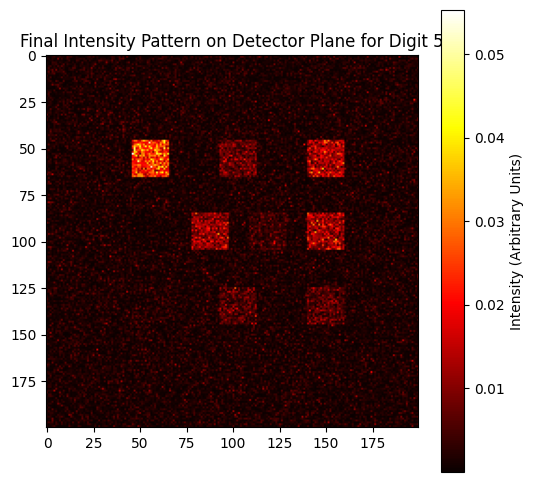

In [10]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

# 确保onn.py和onn文件可用
from onn import Net, detector_region # 导入您的Net和detector_region函数

# 1. 加载模型
model = Net(num_layers=5)
model.load_state_dict(torch.load("./saved_model/136_model.pth", map_location=torch.device('cpu')))
model.eval()

# 2. 准备测试数据
transform = transforms.Compose([transforms.ToTensor()])
test_dataset = torchvision.datasets.MNIST("./data", train=False, transform=transform, download=True)

# 3. 选择一张测试图像进行模拟
# 这里选择一个数字‘5’的图像作为示例
test_image_5, _ = test_dataset[8] # 索引8的图像是数字5
test_image_5 = test_image_5.unsqueeze(0) # 添加batch维度

# 填充图像到200x200
test_image_5_padded = torch.nn.functional.pad(test_image_5, pad=(86, 86, 86, 86))

# 转换为复数光场
input_wave = torch.squeeze(torch.cat((test_image_5_padded.unsqueeze(-1),
                                     torch.zeros_like(test_image_5_padded.unsqueeze(-1))), dim=-1), dim=1)

# 4. 进行模拟推理
with torch.no_grad():
    # 模拟光场在整个网络中的传播
    # 这里我们只运行到最后一步，在detector_region之前
    x = input_wave
    for index, layer in enumerate(model.diffractive_layers):
        temp = layer(x)
        bounded_phase = np.mod(model.phase[index].data.cpu().numpy(), 2 * np.pi)
        exp_j_phase = torch.stack((torch.cos(torch.from_numpy(bounded_phase)),
                                   torch.sin(torch.from_numpy(bounded_phase))), dim=-1)
        x_real = temp[..., 0] * exp_j_phase[..., 0] - temp[..., 1] * exp_j_phase[..., 1]
        x_imag = temp[..., 0] * exp_j_phase[..., 1] + temp[..., 1] * exp_j_phase[..., 0]
        x = torch.stack((x_real, x_imag), dim=-1)
    
    x = model.last_diffractive_layer(x)

    # 计算最终光强分布
    final_intensity = x[..., 0]**2 + x[..., 1]**2

# 5. 可视化结果
# 可视化最终的光强图
plt.figure(figsize=(6, 6))
plt.imshow(final_intensity[0, :, :].cpu().numpy(), cmap='hot')
plt.title('Final Intensity Pattern on Detector Plane for Digit 5')
plt.colorbar(label='Intensity (Arbitrary Units)')

# 可视化探测器区域
detector_outputs = detector_region(final_intensity)
print("Detector outputs for digit 5:", detector_outputs.squeeze().cpu().numpy())

plt.show()

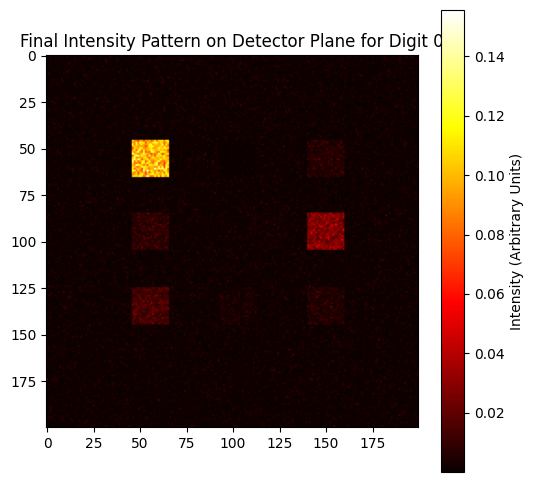

输入数字: 0
探测器输出: [0.10140698 0.0009995  0.00634627 0.00870654 0.00181449 0.00252442
 0.02803132 0.01405074 0.00336198 0.00567522]
模型预测: 0
------------------------------


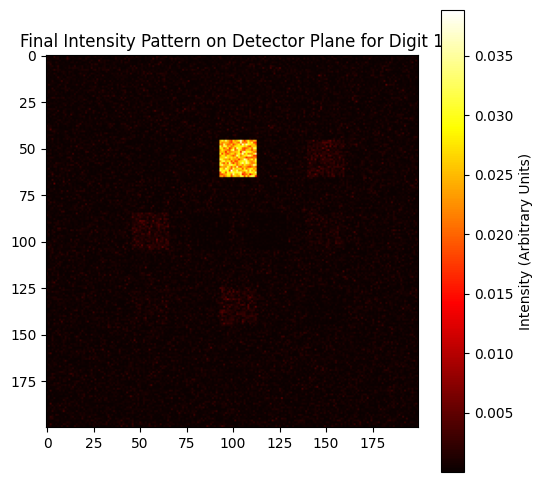

输入数字: 1
探测器输出: [0.00035972 0.02539687 0.00160518 0.00155256 0.00024319 0.00019338
 0.00082813 0.00071595 0.00139676 0.00030415]
模型预测: 1
------------------------------


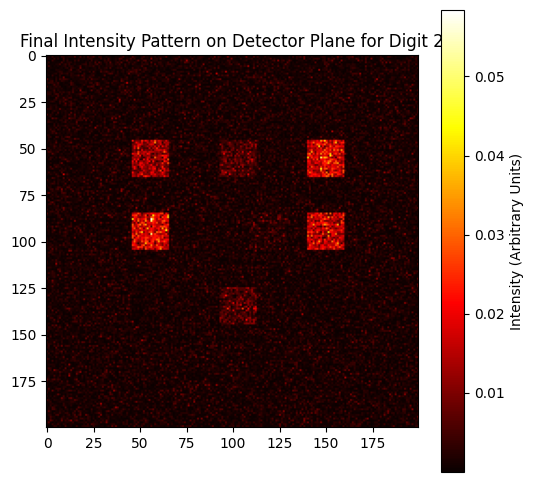

输入数字: 2
探测器输出: [0.01244194 0.00581067 0.01840967 0.01878892 0.0017346  0.00310609
 0.01621515 0.00132979 0.00590932 0.00136654]
模型预测: 3
------------------------------


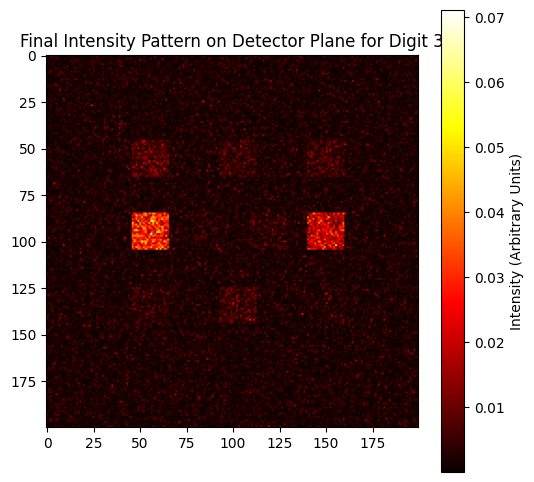

输入数字: 3
探测器输出: [0.00734141 0.00488156 0.00543336 0.02865469 0.00320703 0.00410057
 0.02000513 0.00399073 0.00569219 0.00310847]
模型预测: 3
------------------------------


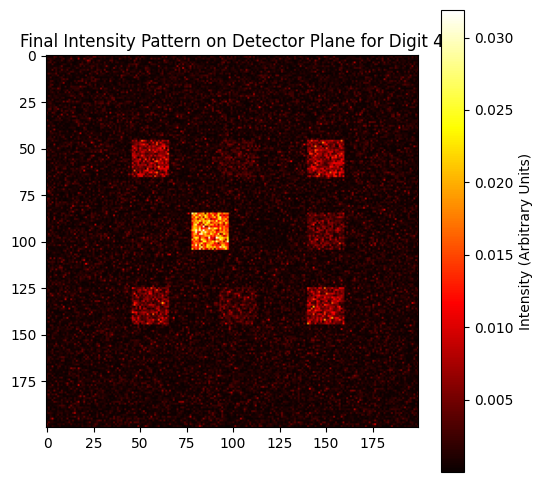

输入数字: 4
探测器输出: [0.00630736 0.00220192 0.00651916 0.00132054 0.01674877 0.00071342
 0.00365985 0.0049204  0.00268976 0.00632738]
模型预测: 4
------------------------------


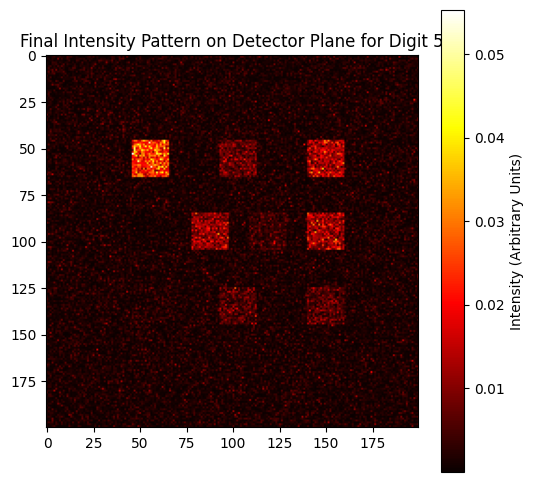

输入数字: 5
探测器输出: [0.02448586 0.00755022 0.01376436 0.00136401 0.01133302 0.00424714
 0.01257931 0.00236905 0.00586257 0.00603781]
模型预测: 0
------------------------------


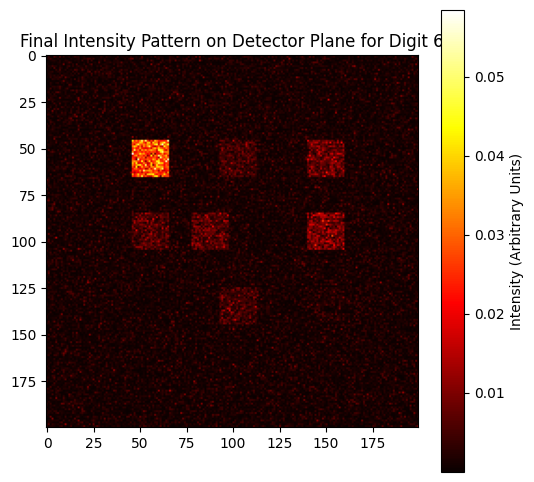

输入数字: 6
探测器输出: [0.02840071 0.00487604 0.00800386 0.00602725 0.00667954 0.00122409
 0.00953983 0.00124209 0.00493844 0.00222153]
模型预测: 0
------------------------------


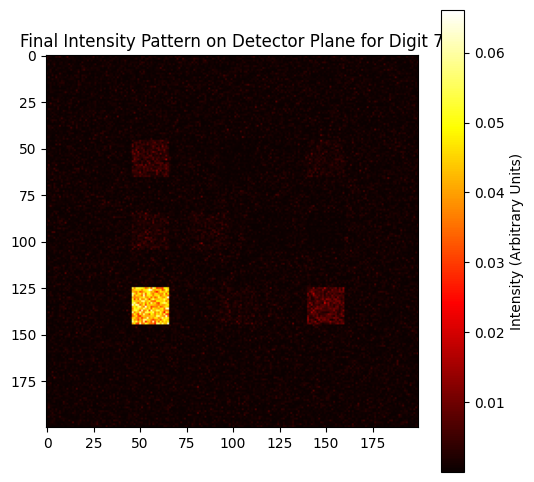

输入数字: 7
探测器输出: [0.00397871 0.00054499 0.00187512 0.00246448 0.00182263 0.00058051
 0.00052288 0.04388501 0.00178196 0.0062981 ]
模型预测: 7
------------------------------


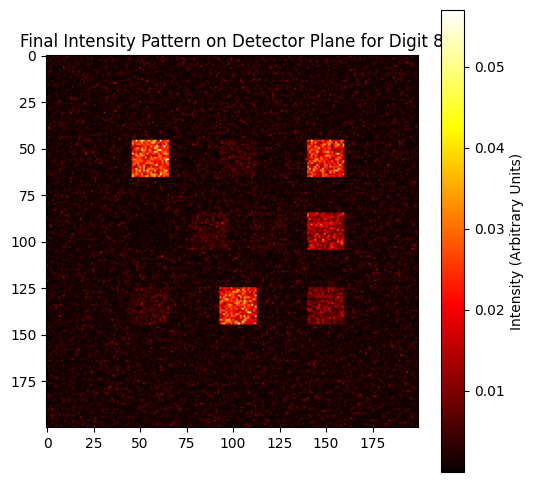

输入数字: 8
探测器输出: [0.02488053 0.00363448 0.02140606 0.00108695 0.00404488 0.00274213
 0.01352252 0.00391572 0.02259227 0.00837574]
模型预测: 0
------------------------------


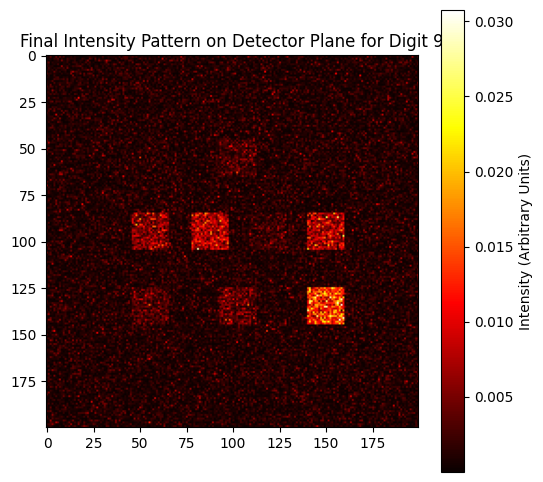

输入数字: 9
探测器输出: [0.00160088 0.00296399 0.00147145 0.00581915 0.00799827 0.00245288
 0.00783312 0.00324192 0.00401094 0.01367323]
模型预测: 9
------------------------------


In [12]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

# 确保onn.py文件可用
from onn import Net, detector_region

# 1. 加载模型
model = Net(num_layers=5)
model.load_state_dict(torch.load("./saved_model/136_model.pth", map_location=torch.device('cpu')))
model.eval()

# 2. 准备测试数据
transform = transforms.Compose([transforms.ToTensor()])
test_dataset = torchvision.datasets.MNIST("./data", train=False, transform=transform, download=True)

# 3. 循环遍历所有数字（0到9）
for target_digit in range(10):

    # 3.1. 找到该数字的一个测试样本
    for image, label in test_dataset:
        if label == target_digit:
            test_image = image
            break # 找到后退出循环

    # 3.2. 填充图像到200x200
    test_image_padded = torch.nn.functional.pad(test_image.unsqueeze(0), pad=(86, 86, 86, 86))
    
    # 3.3. 转换为复数光场
    input_wave = torch.squeeze(torch.cat((test_image_padded.unsqueeze(-1),
                                         torch.zeros_like(test_image_padded.unsqueeze(-1))), dim=-1), dim=1)

    # 4. 进行模拟推理
    with torch.no_grad():
        x = input_wave
        for index, layer in enumerate(model.diffractive_layers):
            temp = layer(x)
            bounded_phase = np.mod(model.phase[index].data.cpu().numpy(), 2 * np.pi)
            exp_j_phase = torch.stack((torch.cos(torch.from_numpy(bounded_phase)),
                                       torch.sin(torch.from_numpy(bounded_phase))), dim=-1)
            x_real = temp[..., 0] * exp_j_phase[..., 0] - temp[..., 1] * exp_j_phase[..., 1]
            x_imag = temp[..., 0] * exp_j_phase[..., 1] + temp[..., 1] * exp_j_phase[..., 0]
            x = torch.stack((x_real, x_imag), dim=-1)
        
        x = model.last_diffractive_layer(x)

        # 4.1. 计算最终光强分布
        final_intensity = x[..., 0]**2 + x[..., 1]**2
    
    # 5. 可视化和分析结果
    plt.figure(figsize=(6, 6))
    plt.imshow(final_intensity[0, :, :].cpu().numpy(), cmap='hot')
    plt.title(f'Final Intensity Pattern on Detector Plane for Digit {target_digit}')
    plt.colorbar(label='Intensity (Arbitrary Units)')
    plt.show()

    detector_outputs = detector_region(final_intensity)
    predicted_digit = torch.argmax(detector_outputs, dim=-1)
    
    print(f"输入数字: {target_digit}")
    print(f"探测器输出: {detector_outputs.squeeze().cpu().numpy()}")
    print(f"模型预测: {predicted_digit.item()}")
    print("-" * 30)